In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn, optim
from torchvision.transforms import transforms
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image 
from IPython.display import display
import matplotlib.pyplot as plt
import pickle

## Check BBox Size

In [3]:
file = open('/content/drive/MyDrive/大四下/MIS/term_project/data_predicted/output_bbox.pkl','rb')
bbox_list = pickle.load(file)

In [4]:
large_dx, large_dy = 0, 0
small_dx, small_dy = 16, 16

for index in range(0, len(bbox_list)):
  for i in range(0, len(bbox_list[index])):
    if bbox_list[index][i][2] - bbox_list[index][i][0] > large_dx:
      large_dx = bbox_list[index][i][2] - bbox_list[index][i][0]
    
    if bbox_list[index][i][3] - bbox_list[index][i][1] > large_dy:
      large_dy = bbox_list[index][i][3] - bbox_list[index][i][1]
    
    if bbox_list[index][i][2] - bbox_list[index][i][0] < small_dx and bbox_list[index][i][2] - bbox_list[index][i][0] != 0:
      small_dx = bbox_list[index][i][2] - bbox_list[index][i][0]
      # print("############################")
      # print(index)
      # print(bbox_list[index][i])
      # print("dx is small: " + str(bbox_list[index][i][2] - bbox_list[index][i][0]))
      # print("dy is " + str(bbox_list[index][i][3] - bbox_list[index][i][1]))
    
    if bbox_list[index][i][3] - bbox_list[index][i][1] < small_dy and bbox_list[index][i][3] - bbox_list[index][i][1] != 0:
      small_dy = bbox_list[index][i][3] - bbox_list[index][i][1]
      # print("############################")
      # print(index)
      # print(bbox_list[index][i])
      # print("dy is small: " + str(bbox_list[index][i][3] - bbox_list[index][i][1]))
      # print("dx is " + str(bbox_list[index][i][2] - bbox_list[index][i][0]))

print(large_dx, large_dy, small_dx, small_dy) 

126.54642486572266 161.08233642578125 4.8690185546875 5.35089111328125


# Make Data

## Settings

In [5]:
padding = False #額外包含邊界資訊 / 原始

## Read in Data

In [6]:
meta = pd.read_csv('/content/drive/MyDrive/大四下/MIS/term_project/data_predicted/Meta/meta_info.csv')
test_img, test_mask, test_true_bbox, test_bbox = [], [], [], []
test_display_index = []
tdi = 0

file = open('/content/drive/MyDrive/大四下/MIS/term_project/data_predicted/bbox.pkl','rb')
test_true_bbox_list = pickle.load(file)
file = open('/content/drive/MyDrive/大四下/MIS/term_project/data_predicted/output_bbox.pkl','rb')
test_bbox_list = pickle.load(file)

### load data

In [7]:
# load data
i_predicted_box = 0
for i in tqdm(range(len(meta.index))):
  # 手動排除
  if meta.iloc[i]['patient_id'] > 475:
    # load image
    if meta.iloc[i]['is_clean'] == False:
      img = np.load('/content/drive/MyDrive/大四下/MIS/term_project/data_predicted/Image/LIDC-IDRI-' + meta.iloc[i]['original_image'][:4] + '/' + meta.iloc[i]['original_image'] + '.npy')
    elif meta.iloc[i]['is_clean'] == True:
      img = np.load('/content/drive/MyDrive/大四下/MIS/term_project/data_predicted/Clean/Image/LIDC-IDRI-' + meta.iloc[i]['original_image'][:4] + '/' + meta.iloc[i]['original_image'] + '.npy')
    img = np.clip(img, -1200, 1200)

    if img.shape[0] != 512 or img.shape[1] != 512:
      print(img.shape, meta.iloc[i]['patient_id'])
    
    # load mask
    if meta.iloc[i]['is_clean'] == False:
      mask = np.load('/content/drive/MyDrive/大四下/MIS/term_project/data_predicted/Mask/LIDC-IDRI-' + meta.iloc[i]['mask_image'][:4] + '/' + meta.iloc[i]['mask_image'] + '.npy')
    elif meta.iloc[i]['is_clean'] == True:
      mask = np.zeros((512, 512))

    # appending data
    if len(test_bbox_list[i_predicted_box]) != 0:
      test_display_index.append(tdi)
      test_true_bbox.append(test_true_bbox_list[i])
      for index in range(0, len(test_bbox_list[i_predicted_box])):
        test_img.append(img)
        test_mask.append(mask)

        x1 = round(test_bbox_list[i_predicted_box][index][0])
        y1 = round(test_bbox_list[i_predicted_box][index][1])
        x2 = round(test_bbox_list[i_predicted_box][index][2])
        y2 = round(test_bbox_list[i_predicted_box][index][3])
        test_bbox.append([x1, y1, x2, y2])
        tdi += 1

    i_predicted_box += 1

100%|██████████| 3395/3395 [09:31<00:00,  5.94it/s]


## Crop Image

In [8]:
def crop_array(ary, x1, y1, x2, y2):
  rst = []
  for y in range(y1, y2+1):
    tmp = ary[y][x1: x2+1]
    rst.append(tmp)
  rst = np.array(rst)
  return rst

def switch_gv(ary):
  rst = []
  for index in range(0, ary.shape[0]):
    rst.append((ary[index] + 1200) / 9.375)
  rst = np.array(rst)
  return rst

def switch_1200(ary):
  rst = []
  for index in range(0, ary.shape[0]):
    rst.append((ary[index] * 9.375) - 1200)
  rst = np.array(rst)
  return rst

def img_with_mask(img, mask):
  rst = []
  for y in range(0, img.shape[0]):
    tmp = []
    for x in range(0, img.shape[1]):
      if mask[y][x] == True:
        tmp.append(1200)
      else:
        tmp.append(img[y][x])
    rst.append(tmp)
  rst = np.array(rst)
  return rst
  

In [9]:
crop_test_img, crop_test_mask = [], []
for index in range(0, len(test_bbox)):
  crop_test_img.append(crop_array(test_img[index], test_bbox[index][0], test_bbox[index][1], test_bbox[index][2], test_bbox[index][3]))
  crop_test_mask.append(crop_array(test_mask[index], test_bbox[index][0], test_bbox[index][1], test_bbox[index][2], test_bbox[index][3]))

In [10]:
print(len(crop_test_img))

303


## Resize成model要吃的大小

In [11]:
def resize_img(img, size_x, size_y):
  imgsize = (size_x, size_y)
  img = switch_gv(img)
  img = Image.fromarray(img)
  img = img.resize(imgsize)
  img = np.array(img)
  img = switch_1200(img)
  return img

def resize_mask(mask, size_x, size_y):
  masksize = (size_x, size_y)
  mask = Image.fromarray(mask)
  mask = mask.resize(masksize, resample = Image.NEAREST)
  mask = np.array(mask)
  mask = (mask==True).astype(int).astype(float)
  return mask

In [12]:
size = 64

resize_train_img, resize_train_mask = [], []
resize_valid_img, resize_valid_mask = [], []
resize_test_img, resize_test_mask = [], []
for index in range(0, len(crop_test_img)):
  resize_test_img.append(resize_img(crop_test_img[index], size, size))
  resize_test_mask.append(resize_mask(crop_test_mask[index], size, size))

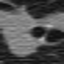

In [13]:
img = switch_gv(crop_test_img[0])
img = Image.fromarray(img)
img.show()
img = switch_gv(resize_test_img[0])
img = Image.fromarray(img)
img.show()

In [14]:
print(len(resize_test_img))
print(resize_test_img[0].shape)

303
(64, 64)


# Model

## UNet

In [15]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class Unet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(Unet, self).__init__()

        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64,out_ch, 1)

    def forward(self,x):
        c1=self.conv1(x)
        p1=self.pool1(c1)
        c2=self.conv2(p1)
        p2=self.pool2(c2)
        c3=self.conv3(p2)
        p3=self.pool3(c3)
        c4=self.conv4(p3)
        p4=self.pool4(c4)
        c5=self.conv5(p4)
        up_6= self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6=self.conv6(merge6)
        up_7=self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7=self.conv7(merge7)
        up_8=self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8=self.conv8(merge8)
        up_9=self.up9(c8)
        merge9=torch.cat([up_9,c1],dim=1)
        c9=self.conv9(merge9)
        c10=self.conv10(c9)
        out = nn.Sigmoid()(c10)
        return out

## Dataset

In [16]:
class MyDataset(Dataset):
    def __init__(self, imgs, masks, transform=None, target_transform=None):
        self.imgs = imgs
        self.masks = masks
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        img_x, img_y = self.imgs[index], self.masks[index]
        if self.transform is not None:
            img_x = self.transform(img_x)
        if self.target_transform is not None:
            img_y = self.target_transform(img_y)
        return img_x, img_y

    def __len__(self):
        return len(self.imgs)

In [17]:
# 是否使用cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [18]:
x_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# mask只需要转换为tensor
y_transforms = transforms.ToTensor()

In [19]:
model = Unet(1, 1).to(device)
batch_size = 8
num_epochs = 20
lr = 0.001
criterion = nn.BCELoss()

## Test

In [21]:
# model.load_state_dict(torch.load('drive/MyDrive/大四下/MIS/term_project/baseline/UNet/weights/weight_no_pad.pth'))
model.load_state_dict(torch.load('drive/MyDrive/大四下/MIS/term_project/baseline/UNet/weights/weight_with_pad.pth'))

model = model.to(device)
dataset = MyDataset(resize_test_img, resize_test_mask, transform=x_transforms, target_transform=y_transforms)
dataloaders = DataLoader(dataset, batch_size=batch_size, shuffle=False)
model.eval()

predictions, ground_truths = [], []
epoch_loss = 0
step = 0
for x, y in dataloaders:
  step += 1
  inputs = x.float().to(device)
  labels = y.float().to(device)
  # forward
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  epoch_loss += loss.item()
  for index in range(0, len(outputs)):
    o = outputs[index][0].float().to('cpu').detach().numpy()
    l = labels[index][0].to('cpu').numpy()
    predictions.append(o) 
    ground_truths.append(l)
print("testing loss:%0.3f" % (epoch_loss/step))
print('-' * 10)

predictions, ground_truths = np.array(predictions), np.array(ground_truths)

thrs_list, iou_list, pre_list, rec_list, dice_list, class_acu_list = [], [], [], [], [], []
class_p_list = []
for num in range(30, 80, 5):
  thrs = num / 100
  thrs_pred = np.where(predictions > thrs, 1, 0)

  gt_equal_pred = np.where(ground_truths==thrs_pred , 1, 0)
  gt_is_false = np.where(np.logical_not(ground_truths), 1, 0)
  tp = np.sum(gt_equal_pred * ground_truths)
  fp = np.sum(thrs_pred) - tp
  fn = np.sum(ground_truths) - tp
  tn = np.sum(gt_equal_pred * gt_is_false)
  iou = tp / (tp + fp + fn)
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  dice = 2*tp / (2*tp + fn + fp)

  thrs_list.append(thrs)
  iou_list.append(iou)
  pre_list.append(precision)
  rec_list.append(recall)
  dice_list.append(dice)

  print('Threshold:', thrs)
  print("iou:", round(iou, 4))
  print("precision:", round(precision, 4))
  print("recall:", round(recall, 4))
  print("dice: ", round(dice, 4))
  print('-' * 10)

testing loss:0.716
----------
Threshold: 0.3
iou: 0.279
precision: 0.4539
recall: 0.4199
dice:  0.4363
----------
Threshold: 0.35
iou: 0.2745
precision: 0.4587
recall: 0.4061
dice:  0.4308
----------
Threshold: 0.4
iou: 0.2698
precision: 0.4634
recall: 0.3924
dice:  0.425
----------
Threshold: 0.45
iou: 0.2651
precision: 0.468
recall: 0.3794
dice:  0.4191
----------
Threshold: 0.5
iou: 0.2602
precision: 0.4729
recall: 0.3665
dice:  0.4129
----------
Threshold: 0.55
iou: 0.2551
precision: 0.4782
recall: 0.3534
dice:  0.4064
----------
Threshold: 0.6
iou: 0.2487
precision: 0.483
recall: 0.339
dice:  0.3984
----------
Threshold: 0.65
iou: 0.2421
precision: 0.4879
recall: 0.3245
dice:  0.3898
----------
Threshold: 0.7
iou: 0.2346
precision: 0.4935
recall: 0.3089
dice:  0.38
----------
Threshold: 0.75
iou: 0.225
precision: 0.4991
recall: 0.2906
dice:  0.3673
----------


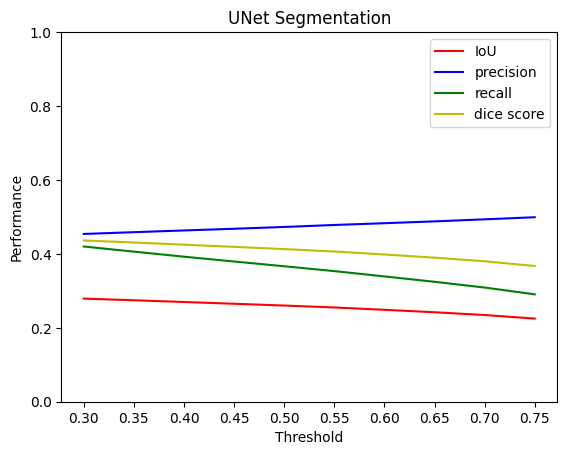

In [22]:
plt.plot(thrs_list, iou_list, 'r', label='IoU')
plt.plot(thrs_list, pre_list, 'b', label='precision')
plt.plot(thrs_list, rec_list, 'g', label='recall')
plt.plot(thrs_list, dice_list, 'y', label='dice score')
plt.xticks(thrs_list)
plt.ylim([0,1]) 
plt.title("UNet Segmentation")
plt.xlabel('Threshold')
plt.ylabel('Performance')
plt.legend()
plt.show()

## 展示預測結果

In [23]:
from google.colab.patches import cv2_imshow
import cv2

# display
d_clean_img, d_img_all = [], []
for i in tqdm(range(0, len(test_display_index))):
  index = test_display_index[i]
  if i != len(test_display_index) - 1:
    num = test_display_index[i + 1] - test_display_index[i]
  else:
    num = len(test_img) - test_display_index[i]
  
  # 乾淨的原始image
  t = switch_gv(test_img[index])
  t = np.repeat(t[:, :, np.newaxis], 3, axis=2)
  d_clean_img.append(t)

  # prediction 和 ground truth 和在一起
  t = switch_gv(test_img[index])
  t = np.repeat(t[:, :, np.newaxis], 3, axis=2)
  
  for n in range(0, num):
    for y in range(0, test_mask[index + n].shape[0]):
      for x in range(0, test_mask[index + n].shape[1]):
        if test_mask[index + n][y][x] == True:
          t[y][x][0] = 0
          t[y][x][1] = 255
          t[y][x][2] = 0


  for n in range(0, num):
    bbox_dx, bbox_dy = test_bbox[index + n][2] - test_bbox[index + n][0] + 1, test_bbox[index + n][3] - test_bbox[index + n][1] + 1
    gt = np.where(ground_truths[index + n] > 0.5, True, False)
    gt = resize_mask(gt, bbox_dx, bbox_dy)
    gt = np.where(gt > 0.5, True, False)
    pdt = np.where(predictions[index + n] > 0.5, True, False)
    pdt = resize_mask(pdt, bbox_dx, bbox_dy)
    pdt = np.where(pdt > 0.5, True, False)

    for y in range(0, gt.shape[0]):
      for x in range(0, gt.shape[1]):
        if gt[y][x] == True and pdt[y][x] == True:
          t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][0] = 255
          t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][1] = 255
          t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][2] = 255
        elif gt[y][x] == True:
          t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][0] = 0
          t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][1] = 0
          t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][2] = 255
        elif pdt[y][x] == True:
          t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][0] = 255
          t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][1] = 0
          t[test_bbox[index + n][1] + y][test_bbox[index + n][0] + x][2] = 0
  d_img_all.append(t)

100%|██████████| 219/219 [02:04<00:00,  1.76it/s]


In [24]:
for index in range(0, len(d_img_all)):
  print(index)
  cv2_imshow(d_img_all[index])
  # cv2.imwrite('drive/MyDrive/大四下/MIS/term_project/baseline/UNet/results/rcnn_no_pad/' + str(index) + '.png', d_img_all[index])
  cv2.imwrite('drive/MyDrive/大四下/MIS/term_project/baseline/UNet/results/rcnn_with_pad/' + str(index) + '.png', d_img_all[index])
  cv2.imwrite('drive/MyDrive/大四下/MIS/term_project/baseline/UNet/results/rcnn_origin_image/' + str(index) + '.png', d_clean_img[index])

Output hidden; open in https://colab.research.google.com to view.